In [6]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('../trackers_saved/ball_detections.pkl','rb') as f:
    ball_positions = pickle.load(f)

In [4]:
ball_positions = [x.get(1,[]) for x in ball_positions]

In [7]:
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [8]:
df_ball_positions.head()

,x1,y1,x2,y2
0,892.072815,615.606628,912.284546,637.328735
1,892.072815,615.606628,912.284546,637.328735
2,878.446899,629.156586,897.867111,650.270935
3,864.820984,642.706543,883.449677,663.213135
4,851.195068,656.256500,869.032242,676.155334


The use of rolling in this context is to smooth out the mid_y values by calculating a moving average. Here’s why and how it’s beneficial:

**Why Use Rolling?**
- Noise Reduction: The individual y-coordinates (y1 and y2) might have small fluctuations or noise due to various factors like slight movements or measurement errors. By calculating a rolling mean, you average out these small fluctuations, providing a smoother and more stable series of values.

- Trend Detection: Smoothing the data helps in identifying underlying trends. For example, in the context of tracking a ball’s position, a rolling mean can help highlight the general movement pattern (upwards, downwards, or stable) more clearly than the raw values.

- Handling Irregular Movements: If the ball moves irregularly or erratically, the rolling mean helps in dampening the effect of sudden spikes or drops, making it easier to analyze the general trajectory.

**How Rolling Works?**
- Window Size: The window=5 parameter specifies that the rolling mean should be calculated over 5 consecutive data points. For each data point, the average of that point and the 4 preceding points is calculated.

- Flexibility with Data: The min_periods=1 parameter allows the rolling mean to be calculated even if fewer than 5 data points are available (useful at the start of the dataset).

- Right-Aligned Window: The center=False parameter means the window is right-aligned, so the rolling mean at each point includes the current point and the previous points within the window.

In [9]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

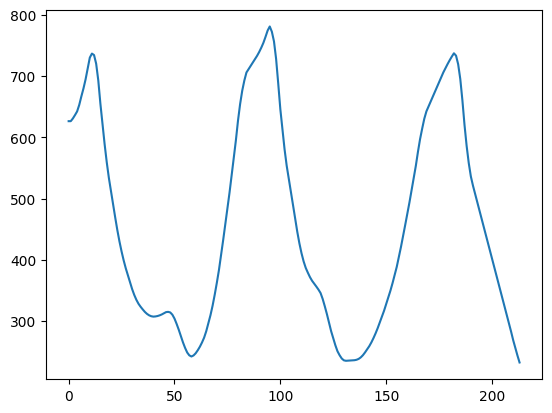

In [10]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [11]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

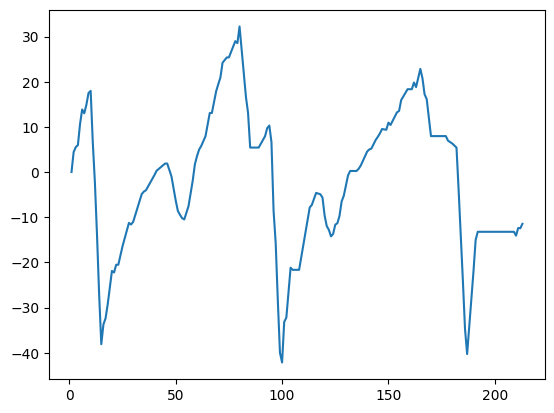

In [12]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])

In [13]:
df_ball_positions['ball_hit']=0

The objective is to identify frames in a video where a ball has been hit. This is done by detecting changes in the ball's vertical position (delta_y) over a sequence of frames.

In [14]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

/var/folders/n5/v74vy_n52_x3y90x7bhwb0lcmqcwlg/T/ipykernel_32876/3752280353.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/n5/v74vy_n52_x3y90x7bhwb0lcmqcwlg/T/ipykernel_32876/37522

1. minimum_change_frames_for_hit = 25

This variable sets the threshold for the minimum number of frames needed to confirm a ball hit. In this case, a hit is confirmed if there are consistent changes in direction for at least 25 frames.

2. for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit * 1.2)):

The loop starts from the second frame (index 1) and goes up to the frame that allows for checking at least minimum_change_frames_for_hit * 1.2 subsequent frames. The 1.2 factor provides a small buffer to ensure there are enough frames to check for changes.

3. 
negative_position_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i + 1] < 0
positive_position_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i + 1] > 0

delta_y represents the change in the ball's vertical position between consecutive frames.
negative_position_change checks if the ball's position changes from moving upwards (positive delta_y) to moving downwards (negative delta_y).
positive_position_change checks if the ball's position changes from moving downwards (negative delta_y) to moving upwards (positive delta_y).

4.
if negative_position_change or positive_position_change:
    change_count = 0 
    for change_frame in range(i + 1, i + int(minimum_change_frames_for_hit * 1.2) + 1):
        negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
        positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

        if negative_position_change and negative_position_change_following_frame:
            change_count += 1
        elif positive_position_change and positive_position_change_following_frame:
            change_count += 1

    if change_count > minimum_change_frames_for_hit - 1:
        df_ball_positions['ball_hit'].iloc[i] = 1


If an initial significant change is detected (negative_position_change or positive_position_change), a nested loop checks for consistent changes in the subsequent frames.
change_count is initialized to 0 to count the number of consistent changes detected.
The nested loop iterates over the frames from i + 1 to i + int(minimum_change_frames_for_hit * 1.2) + 1, checking for consistent direction changes:
negative_position_change_following_frame checks if the initial positive to negative change is followed by another negative change.
positive_position_change_following_frame checks if the initial negative to positive change is followed by another positive change.
change_count is incremented if consistent changes are found.
If change_count exceeds minimum_change_frames_for_hit - 1, the current frame i is marked as a hit by setting df_ball_positions['ball_hit'].iloc[i] = 1.


In [15]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,778.310364,718.130676,796.910034,739.054688,728.592682,736.765204,6.583630,1
58,925.399622,241.120999,938.576697,254.267624,247.694312,242.455722,-1.864975,1
95,616.544312,774.428650,638.354614,798.986755,786.707703,781.004150,6.637500,1
131,717.316040,229.854515,728.352936,241.978798,235.916656,235.445137,-0.760321,1
182,1296.657227,740.082886,1313.343018,758.094238,749.088562,737.274954,5.417377,1


Frames with hit = 11,58,95,131,182